<a href="https://colab.research.google.com/github/suhrobm/Evolutionary-Computing/blob/commonbranch/ec_lab1_Munavarov_Suhrob.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **LAB 1. To train evolutoinary algorithm**
---

### **Content** 🎯

Our purpose is to train evolutoinary algorithm to solve classic optimization function. The function **Rastrigin** was used, but be informed that it is reversed and shifted. The maximum value that we are able to achieve is 10 and this is our goal, of course!


**Notes**

*  Using deap library

In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00


In [2]:
from deap import tools
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from deap import tools, base
from multiprocessing import Pool
from numpy import random as rnd
from deap import creator
from deap import benchmarks


In [3]:
# this block defines how the algorithm works -- ga_scheme.py
def varOr(population, toolbox, lambda_, cxpb, mutpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(toolbox.clone(random.choice(population)))

    return offspring

# the algorithm function that will use all the components we defined
def eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    # evaluate the fitness over all the individuals using 'map '
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        if halloffame is not None:
            for ind in halloffame:
                population.append(toolbox.clone(ind))
        #'varOr' perform cross-over and mutation and get the children,
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook



In [4]:
# draw_log.py

def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
# functions.py

displace = rnd.random()

def rastrigin(individual):
    n = len(individual)
    pi = math.pi
    dn = 1.0 / n
    a = 10.0
    b = 0.2
    c = 2 * pi
    s1 = 0.0
    s2 = 0.0
    for i in range(n):
        s1 += (individual[i]-displace) * (individual[i]-displace)
        s2 += np.cos(c*(individual[i]-displace))
    s1 = -a * math.exp(-b*math.sqrt(dn*s1))
    s2 = -math.exp(dn*s2)
    result = s1+s2 + a + math.exp(1)
    result = -result
    result = result + a
    result = math.fabs(result)
    return result

In [6]:
# ga_exp.py

creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

def mutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.8)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual


In [7]:
class SimpleGAExperiment:
    def factory(self):
        return rnd.random(self.dimension) * 10 - 5

    def __init__(self, function, dimension, pop_size, iterations):
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = 0.97
        self.cross_prob = 0.35

        self.function = function
        self.dimension = dimension

        self.engine = base.Toolbox()
        self.engine.register("map", map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        self.engine.register("mate", tools.cxUniform, indpb=0.15)
        self.engine.register("mutate", tools.mutShuffleIndexes, indpb=0.25)
        self.engine.register("select", tools.selRoulette)
        self.engine.register("evaluate", self.function)


    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(self.pop_size*0.8), cxpb=self.cross_prob, mutpb=self.mut_prob,
                                  ngen=self.iterations,
                                  stats=stats, halloffame=hof, verbose=True)
        print('\n')
        print("Best = {}".format(hof[0]))
        print('\n')
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        print('\n')
        return log


gen	nevals	avg   	std     	min    	max    
0  	100   	3.7686	0.168891	3.39856	4.23439
1  	80    	3.7885	0.17557 	3.37328	4.23439
2  	80    	3.82438	0.183262	3.37328	4.23439
3  	80    	3.8587 	0.190782	3.47517	4.23439
4  	80    	3.85702	0.184705	3.47517	4.25824
5  	80    	3.90856	0.192543	3.47517	4.25824
6  	80    	3.91566	0.201709	3.47517	4.25824
7  	80    	3.89265	0.19463 	3.47517	4.25824
8  	80    	3.94832	0.192086	3.47517	4.25824
9  	80    	3.99272	0.184414	3.47517	4.27658
10 	80    	4.00076	0.183307	3.47517	4.28053
11 	80    	4.03383	0.172411	3.47517	4.34062
12 	80    	4.0611 	0.179937	3.47517	4.34062
13 	80    	4.04495	0.194063	3.47517	4.34062
14 	80    	4.05246	0.184715	3.6539 	4.41392
15 	80    	4.12958	0.186105	3.68948	4.41392
16 	80    	4.14298	0.19584 	3.68948	4.47772
17 	80    	4.16467	0.194517	3.68948	4.47772
18 	80    	4.1725 	0.175091	3.68948	4.48164
19 	80    	4.1866 	0.194119	3.68948	4.56652
20 	80    	4.22058	0.182063	3.68948	4.56652
21 	80    	4.21688	0.180926	3.84476

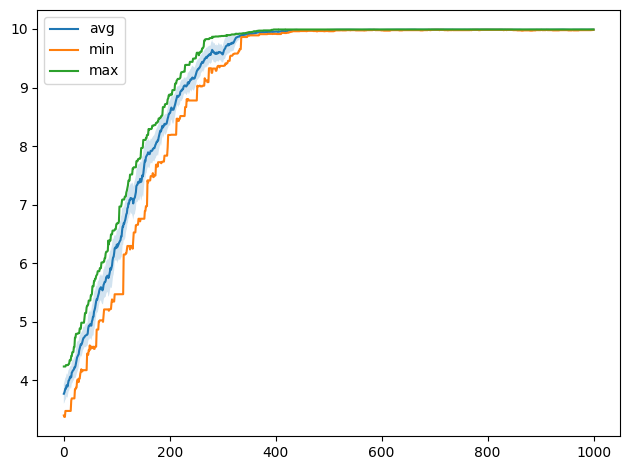

In [8]:
def function(x):
    res = rastrigin(x)
    return res,

dimension = 100 # set to 100
pop_size = 100 # max is 100
iterations = 1000 # max is 10000
scenario = SimpleGAExperiment(function, dimension, pop_size, iterations)
log = scenario.run()

draw_log(log)

### **Conclusion**


*   The algorithm successfully found best fitness value 9.99
*   The fitness value started to stable starting from 600th iteration number
